In [1]:
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
from skimage import draw
from PIL import Image
import os
import numpy as np
import tifffile
def fill(n,x,y,z,v=1,s=4):
    rr,cc=draw.ellipse(int(x),int(y), s, s)
    ir=(rr>0)*(rr<n.shape[0])
    ic=(cc>0)*(cc<n.shape[1])
    ii=ir*ic
    rr=rr[ii]
    cc=cc[ii]
    z1=int(max(0,z-3))
    z2=int(min(100,z+4))

    if z1==z2:
        n[rr,cc,z1]=v
    else:
        n[rr,cc,z1:z2]=v
    return n
def bc(img,th=0):
    x=img!=th
    x=x.sum(axis=0)
    x=(x>0)
    x1=list(x.squeeze()).index(1)
    x2=list(x[::-1].squeeze()).index(1)
    y=img!=th
    y=y.sum(axis=1)
    y=(y>0)
    y1=list(y).index(1)
    y2=list(y[::-1]).index(1)
    return img[y1:img.shape[0]-y2,x1:img.shape[1]-x2]
def ar(v):
    av=v.clone()
    av=torch.zeros([26,v.shape[0],v.shape[1],v.shape[2]])
    zv=torch.zeros([v.shape[0]+2,v.shape[1]+2,v.shape[2]+2])
    zv[1:-1,1:-1,1:-1]=v
    n=0
    
    for x in range(3):
        for y in  range(3):
            for z in range(3):
                if not x==1 and y==1 and z==1:
                    av[n]=zv[x:x+v.shape[0],y:y+v.shape[1],z:z+v.shape[2]]
                    n=n+1
    return av







In [2]:
#!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126
# Run this if torch is not installed

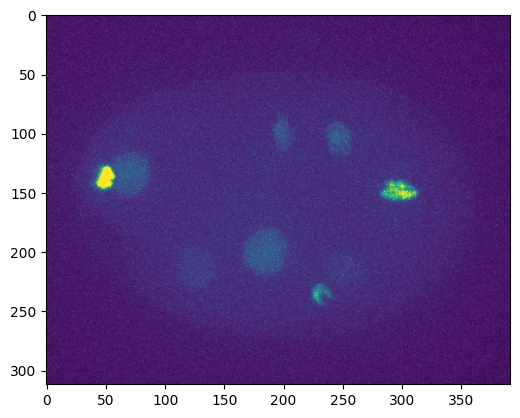

In [3]:
# Load image data

path='./example/'
img=tifffile.TiffFile(path+'mskcc_confocal_s2_t020.tif').asarray().transpose([1,2,0])[100:-100,60:-60]
img2=tifffile.TiffFile(path+'mskcc_confocal_s2_t021.tif').asarray().transpose([1,2,0])[100:-100,60:-60]
img3=tifffile.TiffFile(path+'mskcc_confocal_s2_t022.tif').asarray().transpose([1,2,0])[100:-100,60:-60]
plt.imshow(img.max(-1),vmax=4000)




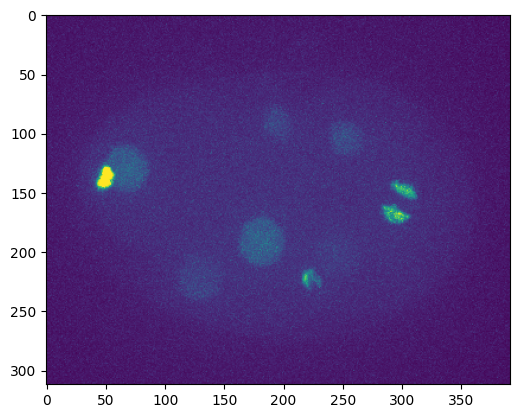

In [4]:
plt.imshow(img2.max(-1),vmax=4000)

In [5]:
# Define the MLP model
import torch.nn as nn
import torch.nn.functional as F
import torch
class EXNet(nn.Module):
    """
    Implementations based on the Unet3D paper: https://arxiv.org/pdf/1706.00120.pdf
    """

    def __init__(self, in_channels, n_classes, base_n_filter=8):
        super(EXNet, self).__init__()
        self.in_channels = in_channels
        self.n_classes = n_classes
        self.base_n_filter = base_n_filter

        self.lrelu = nn.LeakyReLU()
        

        self.l1=nn.Linear(self.in_channels*5, self.in_channels)
        self.l2=nn.Linear(self.in_channels*5, self.in_channels)
        self.l3=nn.Linear(self.in_channels*5, self.in_channels)
        self.l4=nn.Linear(3*5, self.in_channels)
        self.l5=nn.Linear(6*5, self.in_channels)
        self.l6=nn.Linear(6*5, self.in_channels)
        self.bnx=nn.BatchNorm1d(self.in_channels)
        self.bny=nn.BatchNorm1d(self.in_channels)
        self.bn1=nn.BatchNorm1d(self.in_channels)
        self.bn2=nn.BatchNorm1d(self.in_channels)
        self.bn3=nn.BatchNorm1d(self.in_channels)
        self.bn4=nn.BatchNorm1d(self.in_channels)
        self.bn5=nn.BatchNorm1d(self.in_channels)
        self.bn6=nn.BatchNorm1d(self.in_channels)
        self.bn7=nn.BatchNorm1d(self.in_channels*2)
        self.bnc=nn.BatchNorm2d(8)
        self.fc=nn.Linear(self.in_channels*6, self.in_channels*2)
        self.fc2=nn.Linear(self.in_channels*2, self.in_channels)
        self.out=nn.Linear(self.in_channels, self.n_classes)
        self.c1 = nn.Conv2d(1, 8, kernel_size=(2,5), stride=1, padding=(0,2),
                                     bias=False)
        self.c2 = nn.Conv2d(1, 8, kernel_size=(2,3), stride=1, padding=(0,1),
                                     bias=False)
        self.cx=nn.Linear(self.in_channels*8*2, self.in_channels)
        '''self.conv3d_c1_1 = nn.Conv3d(self.in_channels, self.base_n_filter, kernel_size=3, stride=1, padding=1,
                                     bias=False)'''
        self.outc=nn.Linear(self.in_channels+self.n_classes, 2)
        self.d1= nn.Dropout(p=0.1)
        self.d2= nn.Dropout(p=0.1)
        self.s=nn.Sigmoid()
    def forward(self, x,y,p,s,zs):
      
        x01=torch.cat([x,y[:,0].unsqueeze(1)],1)

        x01=self.cx(torch.cat([self.lrelu(self.bnc(self.c1(x01.unsqueeze(1)))),self.lrelu(self.bnc(self.c2(x01.unsqueeze(1))))],1).reshape(x01.shape[0],-1))
  
        x02=torch.cat([x,y[:,1].unsqueeze(1)],1)

        x02=self.cx(torch.cat([self.lrelu(self.bnc(self.c1(x02.unsqueeze(1)))),self.lrelu(self.bnc(self.c2(x02.unsqueeze(1))))],1).reshape(x02.shape[0],-1))
        x03=torch.cat([x,y[:,2].unsqueeze(1)],1)

        x03=self.cx(torch.cat([self.lrelu(self.bnc(self.c1(x03.unsqueeze(1)))),self.lrelu(self.bnc(self.c2(x03.unsqueeze(1))))],1).reshape(x03.shape[0],-1))
        x04=torch.cat([x,y[:,3].unsqueeze(1)],1)

        x04=self.cx(torch.cat([self.lrelu(self.bnc(self.c1(x04.unsqueeze(1)))),self.lrelu(self.bnc(self.c2(x04.unsqueeze(1))))],1).reshape(x04.shape[0],-1))
        x05=torch.cat([x,y[:,4].unsqueeze(1)],1)

        x05=self.cx(torch.cat([self.lrelu(self.bnc(self.c1(x05.unsqueeze(1)))),self.lrelu(self.bnc(self.c2(x05.unsqueeze(1))))],1).reshape(x05.shape[0],-1))
   
        x1=torch.cat([x01,x02,x03,x04,x05],1).reshape(x.shape[0],-1)
        x2=((y-x)).reshape(x.shape[0],-1)
        #x3=(self.bnx(x)*self.bny(y)).reshape(x.shape[0],-1)
        xx=torch.sqrt((x*x).sum(2))
        yy=torch.sqrt((y*y).sum(2))
        xy=x*y
        xy2=(xx*yy).unsqueeze(-1)#.repeat(1,1,xy.shape[-1])
        #print(xy.shape,xy2.shape)
        x3=xy/xy2
        x3=x3.reshape(x.shape[0],-1)
        
        x4=p.reshape(x.shape[0],-1)
        x5=s.reshape(x.shape[0],-1)
        x6=zs.reshape(x.shape[0],-1)
        x1=self.lrelu(self.bn1(self.l1(x1)))
        x2=self.lrelu(self.bn2((self.l2(x2))))
        x3=self.lrelu(self.bn3(self.l3(x3)))
        x4=self.lrelu(self.bn4((self.l4(x4))))
        x5=self.lrelu(self.bn5((self.l5(x5))))
        x6=self.lrelu(self.bn6((self.l6(x6))))
        nx=torch.cat([x1,x2,x3,x4,x5,x6],1)
        #x1=self.lrelu(self.l1(x))
        ui=self.bn7(self.lrelu(self.fc(((nx))) ))
        nx=self.lrelu(self.fc2(ui))
        f=(self.out(nx))   
   
        return f




In [6]:
# Load the pretrained model
tm=2
tm1=1
from unetext3Dn_con7s import UNet3D
os.environ['CUDA_VISIBLE_DEVICES']='0'
device = torch.device("cuda:0")
U =UNet3D(2,6)
EX=EXNet(64,8)
EN=EXNet(64,6)


U.to(device)
EX.to(device)
EN.to(device)


U.load_state_dict(torch.load('./model/U-ext+-x3rdstr0-149.0-3.4599.pth'))
EX.load_state_dict(torch.load('./model/EX+-x3rdstr0-149.0-3.4599.pth'))
EN.load_state_dict(torch.load('./model/EN+-x3rdstr0-149.0-3.4599.pth'))
U.eval()
EX.eval()
EN.eval()
def kflb(x):
    
    kn=torch.zeros([x.shape[0],x.shape[1]+2,x.shape[2]+2,x.shape[3]+2])
    kq=torch.zeros([x.shape[0],27,x.shape[1],x.shape[2],x.shape[3]])
    kn[:,1:-1,1:-1,1:-1]+=x.cpu()
    num=0
    for xc in [-1,0,1]:
        for y in [-1,0,1]:
            for z in [-1,0,1]:
                if np.abs(xc)+max(np.abs(y),np.abs(z))<=1:
                    kq[:,num]=kn[:,xc+1:xc+1+x.shape[1],y+1:y+1+x.shape[2],z+1:z+1+x.shape[3]]
                    num+=1
    return kq

In [7]:
# Define patch/block-wise processing pipeline
DK=np.zeros([tm*2+1,tm*2+1,9])
rr,cc=draw.ellipse(tm,tm, tm,tm)
DK[rr,cc,:]=1
tm=2
tm1=1
DK=torch.from_numpy(DK).float().to(device).reshape([1,1,tm*2+1,tm*2+1,9])
DK1=np.array([[0,0,1,1,1,0,0],[0,1,1,2,1,1,0],[1,1,2,3,2,1,1],[1,2,3,4,3,2,1],[1,1,2,3,2,1,1],[0,1,1,2,1,1,0],[0,0,1,1,1,0,0]])
DK1=torch.from_numpy(DK1).float().to(device).reshape([1,1,7,7,1])#.repeat(1,1,1,1,3)
def kfl(x):
    
    kn=torch.zeros([x.shape[0],x.shape[1]+2,x.shape[2]+2,x.shape[3]+2])
    kq=torch.zeros([x.shape[0],27,x.shape[1],x.shape[2],x.shape[3]])
    kn[:,1:-1,1:-1,1:-1]+=x.cpu()
    num=0
    for xc in [-1,0,1]:
        for y in [-1,0,1]:
            for z in [-1,0,1]:
                if np.abs(xc)+np.abs(y)+np.abs(z)<=1:
                    kq[:,num]=kn[:,xc+1:xc+1+x.shape[1],y+1:y+1+x.shape[2],z+1:z+1+x.shape[3]]
                    num+=1
    return kq
def ud(x):
    x1=torch.zeros_like(x)
    x2=torch.zeros_like(x)
    x1[:,:,:,:,:-1]=x[:,:,:,:,1:]
    x2[:,:,:,:,1:]=x[:,:,:,:,:-1]
    x0=x==0
    xn=(x0*torch.cat([x1,x2],1).max(1)[0]-1)
    
    xn[xn<0]=0
    return x+xn
def vsup256(U,x,la):
   
    Uout,uo,foz,zs1,size1 =  U(x)
    Uf=foz.transpose(0,1)
    
    
    uo1=uo.argmax(1)
    
    uc=((kflb(uo[:,:].max(1)[0]).cuda().max(1)[0]==uo[:,4]))*(kfl(Uout.argmax(1)==0).cuda().sum(1)==0)
    uc[:,:3]=0
    uc[:,-3:]=0
    uc[:,:,:3]=0
    uc[:,:,-3:]=0
    uc[:,:,:,:3]=0
    uc[:,:,:,-2:]=0    
    ar=F.conv3d((uc>0).float().unsqueeze(1), DK1, padding=(3,3,0))
    
    ar=F.conv3d((ar>0).float(), DK1, padding=(3,3,0))
    for i in range(1):
            ar=ud(ar)
             
    u,x,y,z=torch.where(uc.to(device, dtype=torch.float))


    f1=Uf[:,u,x,y,z].transpose(0,1)
    s1=size1[u,0,x,y,z]
    zs1=F.sigmoid(zs1[u,:,x,y,z])

    p1=torch.cat([u.unsqueeze(1),x.unsqueeze(1),y.unsqueeze(1),z.unsqueeze(1)],1)

    return p1,f1,s1,zs1,ar,ar,Uout
def cp2(x,ba,bb,bc):
    aa=((x[:,1])<=ba.max())*((x[:,1])>=ba.min())
    ab=((x[:,2])<=bb.max())*((x[:,2])>=bb.min())
    ac=((x[:,3])<=bc.max())*((x[:,3])>=bc.min())
    return aa*ab*ac
def cp3(x,ba):
    u,x,y,z=x[:,0],x[:,1],x[:,2],x[:,3]
    na=ba[x,y,z]>0
    return na
def bvsup256(U,x,l):
    u,c,pl1,pl2,pl3=x.shape
    pol=256
    polz=32
    pl=pol-8#256-128
    plz=polz-8
    xm,ym,zm=pl1//pl+int(pl1%pl>0),pl2//pl+int(pl2%pl>0),pl3//plz+int(pl3%plz>0)
    p,f,s,zs,lb=[],[],[],[],[]
    plist=[]
    num=0
    uout=torch.zeros([pl1,pl2,pl3])
    ku=torch.zeros([pl1,pl2,pl3])
    kup=torch.zeros([pl1,pl2,pl3])

    for x1 in range(xm):
        for y1 in range(ym):
            for z1 in range(zm):
                num+=1
                ku[ku>1]=1
                
                v1,v2,v3,v4,v5,v6=x1*pl,x1*pl+pol,y1*pl,y1*pl+pol,z1*plz,z1*plz+polz
                if v2>=pl1:
                    v2=pl1-1
                    v1=v2-pol
                if v4>=pl2:
                    v4=pl2-1
                    v3=v4-pol
                if v6>=pl3:
                    v6=pl3-1
                    v5=v6-polz                               
          
                with torch.no_grad():
                    p1,f1,s1,zs1,lb1,ar,uo=  vsup256(U,x[:,:,v1:v2,v3:v4,v5:v6],l[:,v1:v2,v3:v4,v5:v6])  
                uout[v1+5:v2-5,v3+5:v4-5,v5:v6]+=(uo.argmax(1).squeeze().cpu()[5:-5,5:-5]==1).float()
                    
                ar[ar>1]=1
                ar=ar.squeeze().cpu()

                p1[:,1]+=v1
                p1[:,2]+=v3
                p1[:,3]+=v5
                if num>1:
                    
              
                  
                   
                    kn=cp3(p1.cpu(),ku==1)
                    
           
            
                    fn=~kn
                    p1=p1[fn]
                    f1=f1[fn]
                    s1=s1[fn]
                    zs1=zs1[fn]
      
           
                    p=torch.cat([p,p1],0)
                    f=torch.cat([f,f1],0)
                    s=torch.cat([s,s1],0)
                    zs=torch.cat([zs,zs1],0)
              
                else:
                    p=p1
                    f=f1
                    s=s1
                    zs=zs1
            
                ku[v1:v2,v3:v4,v5:v6]+=ar

    return p,f,zs,s,s,uout

In [8]:
# Define preprocessing and run the model
def PA(x):

    x=torch.log1p(x)
    return x
inputs = torch.from_numpy(img).unsqueeze(0).unsqueeze(0)
in2 = torch.from_numpy(img2).unsqueeze(0).unsqueeze(0)
in3 = torch.from_numpy(img3).unsqueeze(0).unsqueeze(0)
labels=torch.zeros(img3.shape).unsqueeze(0).cuda()    
with torch.no_grad():
     
  p1,f1,zs1,s1,lb1,_ =  bvsup256(U,(PA(torch.cat([inputs,in2],1).to(device))),labels)
            

  p2,f2,zs2,s2,lb2,_ =  bvsup256(U,(PA(torch.cat([in2,in3],1)).to(device)),labels) 

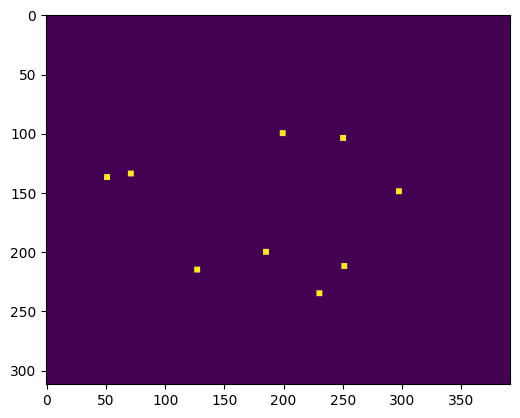

In [9]:
# Visualize the predicted coordinates
def fill2(n,x,y,v=1,s=8):
    rr,cc=draw.ellipse(int(x),int(y), s, s)
    ir=(rr>0)*(rr<n.shape[0])
    ic=(cc>0)*(cc<n.shape[1])
    ii=ir*ic
    rr=rr[ii]
    cc=cc[ii]
   
    n[rr,cc]=v
    
    return n
wx=np.zeros(img.shape[:2])

for i1 in range(p1.shape[0]):
       u,x,y,z=p1[i1]
       wx=fill2(wx,x.item(),y.item(),v=1,s=3)
plt.imshow(wx)


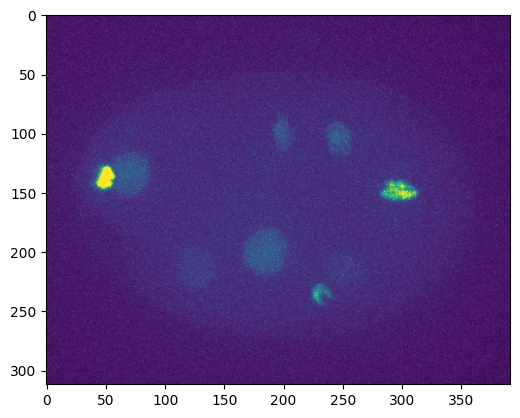

In [10]:
plt.imshow(img.max(-1),vmax=4000)

In [11]:
# Find nearest neighbor cells
m, n = p1.shape[0], p2.shape[0]
px1=p1[:,1:]
py1=p2[:,1:]
distmat = torch.pow(px1.float(), 2).sum(dim=1, keepdim=True).expand(m, n) + \
      torch.pow(py1.float(), 2).sum(dim=1, keepdim=True).expand(n, m).t()
distmat.addmm_(1, -2, px1.float(),py1.float().t())
qx,q=distmat.topk(min(10,px1.shape[0],py1.shape[0]),largest=False)
q#nearest cell#

C:\Users\z\AppData\Local\Temp\ipykernel_8016\1198324190.py:7: UserWarning: This overload of addmm_ is deprecated:
	addmm_(Number beta, Number alpha, Tensor mat1, Tensor mat2)
Consider using one of the following signatures instead:
	addmm_(Tensor mat1, Tensor mat2, *, Number beta = 1, Number alpha = 1) (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\python_arg_parser.cpp:1661.)
  distmat.addmm_(1, -2, px1.float(),py1.float().t())


tensor([[ 0,  1,  3,  4,  5,  9, 10,  8,  2],
        [ 1,  0,  9, 10,  4,  5,  3,  8,  6],
        [ 2,  7,  6,  3,  0,  8,  1,  4,  5],
        [ 3,  8,  6,  4,  5,  0, 10,  1,  9],
        [ 5,  4,  8, 10,  3,  9,  1,  6,  0],
        [ 6,  3,  8,  2,  7,  4,  5,  0,  1],
        [ 7,  2,  6,  3,  0,  8,  1,  4,  5],
        [ 8,  5,  4,  3, 10,  6,  9,  1,  0],
        [ 9, 10,  1,  4,  5,  8,  0,  3,  6]], device='cuda:0')

In [12]:
# Run MLP to get a score for each cell
ey=[]
ep=[]
es=[]
ezs=[]
qf=f1
gf=f2
py=py1
px=px1
for jk in range(5):
    ey.append(gf[q[:,jk].unsqueeze(1)])
    t=py[q[:,jk]]-px
    ep.append(torch.abs(t).unsqueeze(1))
epy=torch.cat(ep,1).float()
ey=torch.cat(ey,1)
epyy=torch.sqrt((epy*epy).sum(-1))
efy=torch.sqrt((epy*epy)[:,:,:2].sum(-1))

for jk in range(5):
    ts1=s2[q[:,jk]]
    es.append(torch.cat([(ts1-s1).unsqueeze(1),(ts1/(s1+1)).unsqueeze(1),
                         epyy[:,jk].unsqueeze(1),(ts1-epyy[:,jk]).unsqueeze(1),((ts1-epyy[:,jk])>0).float().unsqueeze(1),(ts1/(epyy[:,jk]+0.0001)).unsqueeze(1)],1).unsqueeze(1))
    tzs1=zs2[q[:,jk]]
    ezs.append(torch.cat([zs1.unsqueeze(1),tzs1.unsqueeze(1),torch.cat([((zs1[:,0]>0.5)*(tzs1[:,1]>0.5)).unsqueeze(1).float(),((zs1[:,0])*(tzs1[:,1])).unsqueeze(1)],1).unsqueeze(1)],2))

esp=torch.cat(es,1)
ezsp=torch.cat(ezs,1)

with torch.no_grad():
    score=(EX(qf.unsqueeze(1),ey,epy.float(),esp,ezsp))
    sp=score[:,-2:]
    score=F.sigmoid(score[:,:-2])
score

tensor([[1.0000e+00, 6.7087e-04, 2.3352e-06, 3.1159e-07, 2.6071e-08, 5.3410e-05],
        [1.0000e+00, 1.6118e-04, 5.4622e-05, 5.8701e-06, 3.9296e-06, 3.6421e-06],
        [1.0000e+00, 2.6200e-03, 4.8244e-08, 1.0636e-08, 1.4977e-08, 7.0815e-06],
        [1.0000e+00, 2.2850e-05, 8.2676e-07, 1.6015e-05, 1.4104e-05, 1.3425e-05],
        [8.0820e-01, 9.9894e-01, 3.3475e-02, 6.3498e-05, 4.8667e-06, 1.0980e-03],
        [1.0000e+00, 1.8730e-05, 1.1459e-06, 1.5517e-07, 3.2224e-08, 5.3693e-04],
        [9.9666e-01, 3.2288e-02, 6.0177e-10, 1.1717e-10, 1.7616e-09, 1.4444e-02],
        [9.7825e-01, 5.2737e-03, 1.2465e-02, 1.1397e-05, 1.0064e-07, 3.2109e-02],
        [1.0000e+00, 9.9997e-01, 6.9276e-03, 5.3751e-05, 5.2995e-05, 2.2863e-08]],
       device='cuda:0')